In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import brier_score_loss as BS
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV

| 字段   | 说明                           |
| :----- | :----------------------------- |
| label  | 0 负向，1 正向 |
| review | 微博内容                       |

In [2]:
data = pd.read_pickle("weibo_senti_100k_preprocessing.pkl.bz2")

data.sample(20)

,label,review
32001,正向,都行 永远 活在 硬盘 中 大菲 视频 上传 嘻嘻 嘻哈 包袱 铺 王惟 嘻哈 包袱 铺 王...
87593,负向,新 阳光明媚 感觉 时间 过得 真快 周五 做 完 事 难以 停歇 抓狂
81298,负向,拼 拼拼 毕业 说 创意 工坊 完 真心 厦门 白去 泪
23150,正向,怎么着 成 爱 爱 爱
108372,负向,坐过 确实 空调车 两块钱 空调 算 奢侈 黄洁 这是 年 年 美的 超级 无敌 鸡蛋壳 啊...
283,正向,请 西方 势力 说三道四 法新社 交给 金
68362,负向,想 嚏 成功 鼻子 眼 直流 超 痛苦 泪
19531,正向,新书 上市 嘻嘻
36448,正向,多谢 嘻嘻 做 兵心耀阳 关注 含笑 大哥 真实 有心 公益 做 值得 学习 钢子 回复 新...
19719,正向,转发 小佰 额外 礼物 嘻嘻 小小 白玉 蜗牛 测试报告 答案 享乐 型 旅行 败家 爷们 ...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119988 entries, 0 to 119987
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   119988 non-null  object
 1   review  119988 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [4]:
data["label"].value_counts()

负向    59995
正向    59993
Name: label, dtype: int64

In [5]:
X, y = data.iloc[:, 1], data.iloc[:, 0]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5, random_state=520)

In [6]:
X_train.shape

(59994,)

In [7]:
for i in [X_train, X_test, Y_train, Y_test]:
    i.index = range(i.shape[0])

In [8]:
le = LabelEncoder().fit(Y_train)

Y_train = le.transform(Y_train)
Y_test = le.transform(Y_test)

In [9]:
le.classes_

array(['正向', '负向'], dtype=object)

In [10]:
tfidf = TfidfVectorizer().fit(X_train)

X_train_ = tfidf.transform(X_train)
X_test_ = tfidf.transform(X_test)

In [11]:
mnb = MultinomialNB().fit(X_train_, Y_train)

In [12]:
mnb.score(X_train_, Y_train)

0.8884388438843884

In [13]:
mnb.score(X_test_, Y_test)

0.7721438810547722

In [14]:
cnb = ComplementNB().fit(X_train_, Y_train)

In [15]:
cnb.score(X_train_, Y_train)

0.8884388438843884

In [16]:
cnb.score(X_test_, Y_test)

0.7721438810547722

In [17]:
name = ["Multinomial", "Complement", "Bournulli"]

# 注意高斯朴素贝叶斯不接受稀疏矩阵
models = [MultinomialNB(), ComplementNB(), BernoulliNB()]
for name, clf in zip(name, models):
    clf.fit(X_train_, Y_train)
    y_pred = clf.predict(X_test_)
    proba = clf.predict_proba(X_test_)
    score = clf.score(X_test_, Y_test)
    print(name)
    
    # 4个不同的标签取值下的布里尔分数
    Bscore = []
    for i in range(len(np.unique(Y_train))):
        bs = BS(Y_test == i, proba[:, i], pos_label=1)
        Bscore.append(bs)
        print("\tBrier under {}:{:.3f}".format(le.classes_[i],bs))
        
    print("\tAverage Brier:{:.3f}".format(np.mean(Bscore)))
    print("\tAccuracy:{:.3f}".format(score))
    print("\n")

Multinomial
	Brier under 正向:0.159
	Brier under 负向:0.159
	Average Brier:0.159
	Accuracy:0.772


Complement
	Brier under 正向:0.159
	Brier under 负向:0.159
	Average Brier:0.159
	Accuracy:0.772


Bournulli
	Brier under 正向:0.155
	Brier under 负向:0.155
	Average Brier:0.155
	Accuracy:0.792




In [18]:
name = ["Multinomial"
       ,"Multinomial + Isotonic"
       ,"Multinomial + Sigmoid"
       ,"Complement"
       ,"Complement + Isotonic"
       ,"Complement + Sigmoid"
       ,"Bernoulli"
       ,"Bernoulli + Isotonic"
       ,"Bernoulli + Sigmoid"]

models = [MultinomialNB()
         ,CalibratedClassifierCV(MultinomialNB(), cv=5, method='isotonic')
         ,CalibratedClassifierCV(MultinomialNB(), cv=5, method='sigmoid')
         ,ComplementNB()
         ,CalibratedClassifierCV(ComplementNB(), cv=5, method='isotonic')
         ,CalibratedClassifierCV(ComplementNB(), cv=5, method='sigmoid')
         ,BernoulliNB()
         ,CalibratedClassifierCV(BernoulliNB(), cv=5, method='isotonic')
         ,CalibratedClassifierCV(BernoulliNB(), cv=5, method='sigmoid')
         ]

for name, clf in zip(name, models):
    clf.fit(X_train_, Y_train)
    y_pred = clf.predict(X_test_)
    proba = clf.predict_proba(X_test_)
    score = clf.score(X_test_, Y_test)
    print(name)
    
    # 4个不同的标签取值下的布里尔分数
    Bscore = []
    for i in range(len(np.unique(Y_train))):
        bs = BS(Y_test == i, proba[:, i], pos_label=1)
        Bscore.append(bs)
        print("\tBrier under {}:{:.3f}".format(le.classes_[i],bs))
        
    print("\tAverage Brier:{:.3f}".format(np.mean(Bscore)))
    print("\tAccuracy:{:.3f}".format(score))
    print("\n")

Multinomial
	Brier under 正向:0.159
	Brier under 负向:0.159
	Average Brier:0.159
	Accuracy:0.772


Multinomial + Isotonic
	Brier under 正向:0.150
	Brier under 负向:0.150
	Average Brier:0.150
	Accuracy:0.778


Multinomial + Sigmoid
	Brier under 正向:0.150
	Brier under 负向:0.150
	Average Brier:0.150
	Accuracy:0.779


Complement
	Brier under 正向:0.159
	Brier under 负向:0.159
	Average Brier:0.159
	Accuracy:0.772


Complement + Isotonic
	Brier under 正向:0.150
	Brier under 负向:0.150
	Average Brier:0.150
	Accuracy:0.778


Complement + Sigmoid
	Brier under 正向:0.150
	Brier under 负向:0.150
	Average Brier:0.150
	Accuracy:0.779


Bernoulli
	Brier under 正向:0.155
	Brier under 负向:0.155
	Average Brier:0.155
	Accuracy:0.792


Bernoulli + Isotonic
	Brier under 正向:0.146
	Brier under 负向:0.146
	Average Brier:0.146
	Accuracy:0.794


Bernoulli + Sigmoid
	Brier under 正向:0.147
	Brier under 负向:0.147
	Average Brier:0.147
	Accuracy:0.795




In [40]:
alpha_list = np.linspace(1, 10, 20)
print("BernoulliNB + Isotonic")

bsm = []
acc = []

for alpha in alpha_list:
    clf = CalibratedClassifierCV(BernoulliNB(alpha=alpha), cv=5, method='isotonic')
    clf.fit(X_train_, Y_train)
    y_pred = clf.predict(X_test_)
    proba = clf.predict_proba(X_test_)
    score = clf.score(X_test_, Y_test)
    
    # 4个不同的标签取值下的布里尔分数
    print(alpha)
    Bscore = []
    for i in range(len(np.unique(Y_train))):
        bs = BS(Y_test == i, proba[:, i], pos_label=1)
        Bscore.append(bs)
        print("\tBrier under {}:{:.3f}".format(le.classes_[i],bs))
        
    print("\tAverage Brier:{:.3f}".format(np.mean(Bscore)))
    print("\tAccuracy:{:.3f}".format(score))
    print("\n")
    bsm.append(np.mean(Bscore))
    acc.append(score)

BernoulliNB + Isotonic
1.0
	Brier under 正向:0.146
	Brier under 负向:0.146
	Average Brier:0.146
	Accuracy:0.794


1.4736842105263157
	Brier under 正向:0.144
	Brier under 负向:0.144
	Average Brier:0.144
	Accuracy:0.797


1.9473684210526314
	Brier under 正向:0.142
	Brier under 负向:0.142
	Average Brier:0.142
	Accuracy:0.799


2.4210526315789473
	Brier under 正向:0.141
	Brier under 负向:0.141
	Average Brier:0.141
	Accuracy:0.800


2.894736842105263
	Brier under 正向:0.141
	Brier under 负向:0.141
	Average Brier:0.141
	Accuracy:0.801


3.3684210526315788
	Brier under 正向:0.140
	Brier under 负向:0.140
	Average Brier:0.140
	Accuracy:0.801


3.8421052631578947
	Brier under 正向:0.139
	Brier under 负向:0.139
	Average Brier:0.139
	Accuracy:0.802


4.315789473684211
	Brier under 正向:0.139
	Brier under 负向:0.139
	Average Brier:0.139
	Accuracy:0.802


4.789473684210526
	Brier under 正向:0.139
	Brier under 负向:0.139
	Average Brier:0.139
	Accuracy:0.802


5.263157894736842
	Brier under 正向:0.138
	Brier under 负向:0.138
	Average Brier:

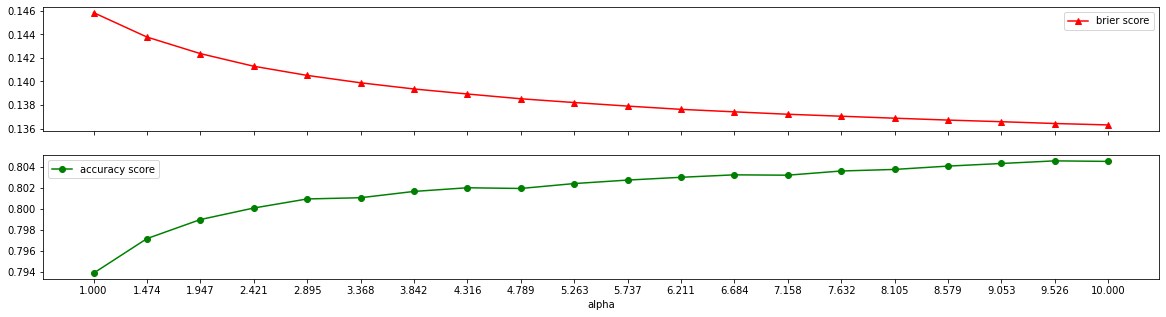

In [41]:
# 画图
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,5))
ax1.plot(alpha_list, bsm, 'r^-', label="brier score")
ax2.plot(alpha_list, acc, 'go-', label="accuracy score")
ax2.set_xticks(alpha_list)
ax1.legend()
ax2.legend()
ax2.set_xlabel("alpha")
# plt.ylabel("score")
plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression
logi = LogisticRegression(max_iter=100).fit(X_train_, Y_train)

In [21]:
logi.score(X_train_, Y_train)

0.8901390139013902

In [22]:
logi.score(X_test_, Y_test)

0.8088308830883089

In [42]:
logi.n_iter_

array([58])

In [43]:
from sklearn.metrics import recall_score

for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    logi = LogisticRegression(solver=solver).fit(X_train_, Y_train)
    y_pred = clf.predict(X_test_)
    proba = clf.predict_proba(X_test_)
    score = clf.score(X_test_, Y_test)
    
    # 4个不同的标签取值下的布里尔分数
    print(solver)
    Bscore = []
    for i in range(len(np.unique(Y_train))):
        bs = BS(Y_test == i, proba[:, i], pos_label=1)
        Bscore.append(bs)
        print("\tBrier under {}:{:.3f}".format(le.classes_[i],bs))
    
    print("\tRecall score :{:.3f}".format(recall_score(Y_test, y_pred)))

    print("\tAverage Brier:{:.3f}".format(np.mean(Bscore)))
    print("\tAccuracy:{:.3f}".format(score))
    print("\n")

newton-cg
	Brier under 正向:0.136
	Brier under 负向:0.136
	Recall score :0.826
	Average Brier:0.136
	Accuracy:0.805


lbfgs
	Brier under 正向:0.136
	Brier under 负向:0.136
	Recall score :0.826
	Average Brier:0.136
	Accuracy:0.805


liblinear
	Brier under 正向:0.136
	Brier under 负向:0.136
	Recall score :0.826
	Average Brier:0.136
	Accuracy:0.805


sag
	Brier under 正向:0.136
	Brier under 负向:0.136
	Recall score :0.826
	Average Brier:0.136
	Accuracy:0.805


saga
	Brier under 正向:0.136
	Brier under 负向:0.136
	Recall score :0.826
	Average Brier:0.136
	Accuracy:0.805




In [44]:
# 网格搜索查找比较好的超参数
from sklearn.model_selection import GridSearchCV
param_grid = {
    'penalty':['l1', 'l2', 'elasticnet', 'none'], 
    'C': np.linspace(0, 1, 50)
}

logi = LogisticRegression()
gs = GridSearchCV(logi, param_grid, cv=5)

In [45]:
# 16 min
gs.fit(X_train_, Y_train)

f:\MyProject\practice\clea_sample\venv\lib\site-packages\sklearn\linear_model\_logistic.py:811: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1.0 / C, sample_weight),
f:\MyProject\practice\clea_sample\venv\lib\site-packages\sklearn\linear_model\_logistic.py:122: RuntimeWarning: invalid value encountered in double_scalars
  out = -np.sum(sample_weight * log_logistic(yz)) + 0.5 * alpha * np.dot(w, w)
f:\MyProject\practice\clea_sample\venv\lib\site-packages\sklearn\linear_model\_logistic.py:127: RuntimeWarning: invalid value encountered in multiply
  grad[:n_features] = safe_sparse_dot(X.T, z0) + alpha * w
f:\MyProject\practice\clea_sample\venv\lib\site-packages\sklearn\linear_model\_logistic.py:811: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1.0 / C, sample_weight),
f:\MyProject\practice\clea_sample\venv\lib\site-packages\sklearn\linear_model\_logistic.py:122: RuntimeWarning: invalid value encountered in double_scalar

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']})

In [46]:
gs.best_estimator_

LogisticRegression(C=0.836734693877551)

In [47]:
gs.score(X_train_, Y_train)

0.8829549621628829

In [48]:
gs.score(X_test_, Y_test)

0.8094309430943094

In [51]:
gs.best_params_

{'C': 0.836734693877551, 'penalty': 'l2'}

In [49]:
recall_score(Y_test, gs.predict(X_test_))

0.8577902172464348

In [50]:
from sklearn.metrics import precision_score
precision_score(Y_test, gs.predict(X_test_))

0.7822784040839892

In [52]:
logi = LogisticRegression(C=0.836734693877551)
logi.fit(X_train_, Y_train)

LogisticRegression(C=0.836734693877551)

In [54]:
logi.score(X_train_, Y_train)

0.8829549621628829

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

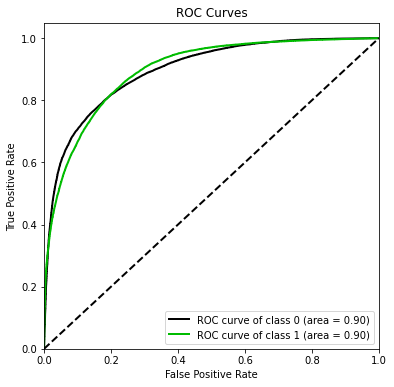

In [53]:
import scikitplot as skplt

vali_proba_df = pd.DataFrame(logi.predict_proba(X_test_))
skplt.metrics.plot_roc(Y_test, vali_proba_df
                        ,plot_micro=False
                        ,figsize=(6,6)
                        ,plot_macro=False
                        )
# 两者都很不错，相对于朴素贝叶斯，逻辑回归在文本情感上有更好的表现